In [1]:
%%capture
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from facedetector import FaceDetector

2025-12-01 21:20:13.507448: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 21:20:13.507758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 21:20:13.548432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 21:20:14.585035: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-poin

In [2]:
DATASET_PATH = '/home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/'

In [3]:
dirs1 = os.listdir(DATASET_PATH)
original_dir    = DATASET_PATH + dirs1[0]
manipulated_dir = DATASET_PATH + dirs1[1]

print("ORIGINAL:\t",original_dir)
print("MANIPULATED:\t",manipulated_dir)

ORIGINAL:	 /home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/original_sequences
MANIPULATED:	 /home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/manipulated_sequences


In [4]:
def get_path_to_images(base_dir, v=False):
    dirs1 = os.listdir(base_dir)
    base_dirs = []
    
    for i in dirs1:
        if 'images' in os.listdir(base_dir + '/' + i + '/c23/'):
            base_dirs.append(base_dir + '/' + i + '/c23/images/')
    
    if v:
        print("found", len(base_dirs), "base directories")
        for i in base_dirs:
            print(f"\t{i}")
    
        print("")
    # Locate directories
    
    dirs = []
    
    for base in base_dirs:
        end_paths = os.listdir(base)
        for end in end_paths:
            dirs.append(base + end + '/')
    if v:
        print("found", len(dirs), "base directories")
        # for i in dirs:
        #     print(f"\t{i}")
    return dirs

In [5]:
## ORIGINAL
orig_dirs = get_path_to_images(original_dir, v=True)

found 2 base directories
	/home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/original_sequences/actors/c23/images/
	/home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/original_sequences/youtube/c23/images/

found 1363 base directories


In [6]:
## FAKE
fake_dirs = get_path_to_images(manipulated_dir, v=True)

found 4 base directories
	/home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/manipulated_sequences/FaceShifter/c23/images/
	/home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/manipulated_sequences/Deepfakes/c23/images/
	/home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/manipulated_sequences/Face2Face/c23/images/
	/home/ubuntu/hf_env/Project/dataset_FaceForensics/dataset/manipulated_sequences/FaceSwap/c23/images/

found 3177 base directories


In [7]:
# For Each directory, display an image

In [ ]:
def extract_faces_from_image(image_input, output_shape=(299, 299), padding=1.0):

    # Standardize img
    if isinstance(image_input, Image.Image):
        pil_image = image_input.convert('RGB')
        numpy_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    
    elif isinstance(image_input, np.ndarray):
        numpy_image = image_input
        pil_image = Image.fromarray(cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB))
    
    else:
        raise ValueError("Format non supporté. Utilisez une image PIL ou un array Numpy.")

    # face detection
    try:
        faces = FaceDetector.detect(numpy_image)
    except Exception as e:
        print(f"Erreur lors de la détection : {e}")
        return []

    extracted_faces = []

    # Extraction + treatment
    for face in faces:
        bbox = face['bounding_box']
        pivotX, pivotY = face['pivot']
        
        # ignore face if it's too small
        if bbox['width'] < 50 or bbox['height'] < 100:
            continue
        
        # add padding
        left = pivotX - bbox['width'] / 2.0 * padding
        top = pivotY - bbox['height'] / 2.0 * padding
        right = pivotX + bbox['width'] / 2.0 * padding
        bottom = pivotY + bbox['height'] / 2.0 * padding
        
        # crop using PIL
        cropped = pil_image.crop((int(left), int(top), int(right), int(bottom)))
        
        # resize
        # KANCZOS is used to avoid quality loss
        resized_face = cropped.resize(output_shape, Image.Resampling.LANCZOS)
        
        extracted_faces.append(resized_face)

    return extracted_faces

In [9]:
# Load 1 image/dir
real_images = []
for path in orig_dirs[:1000]: # cannot open too much images at the same time, that would kill PIL
    real_images.append(Image.open(path + '0000.png')) # 0000 for the 1st image

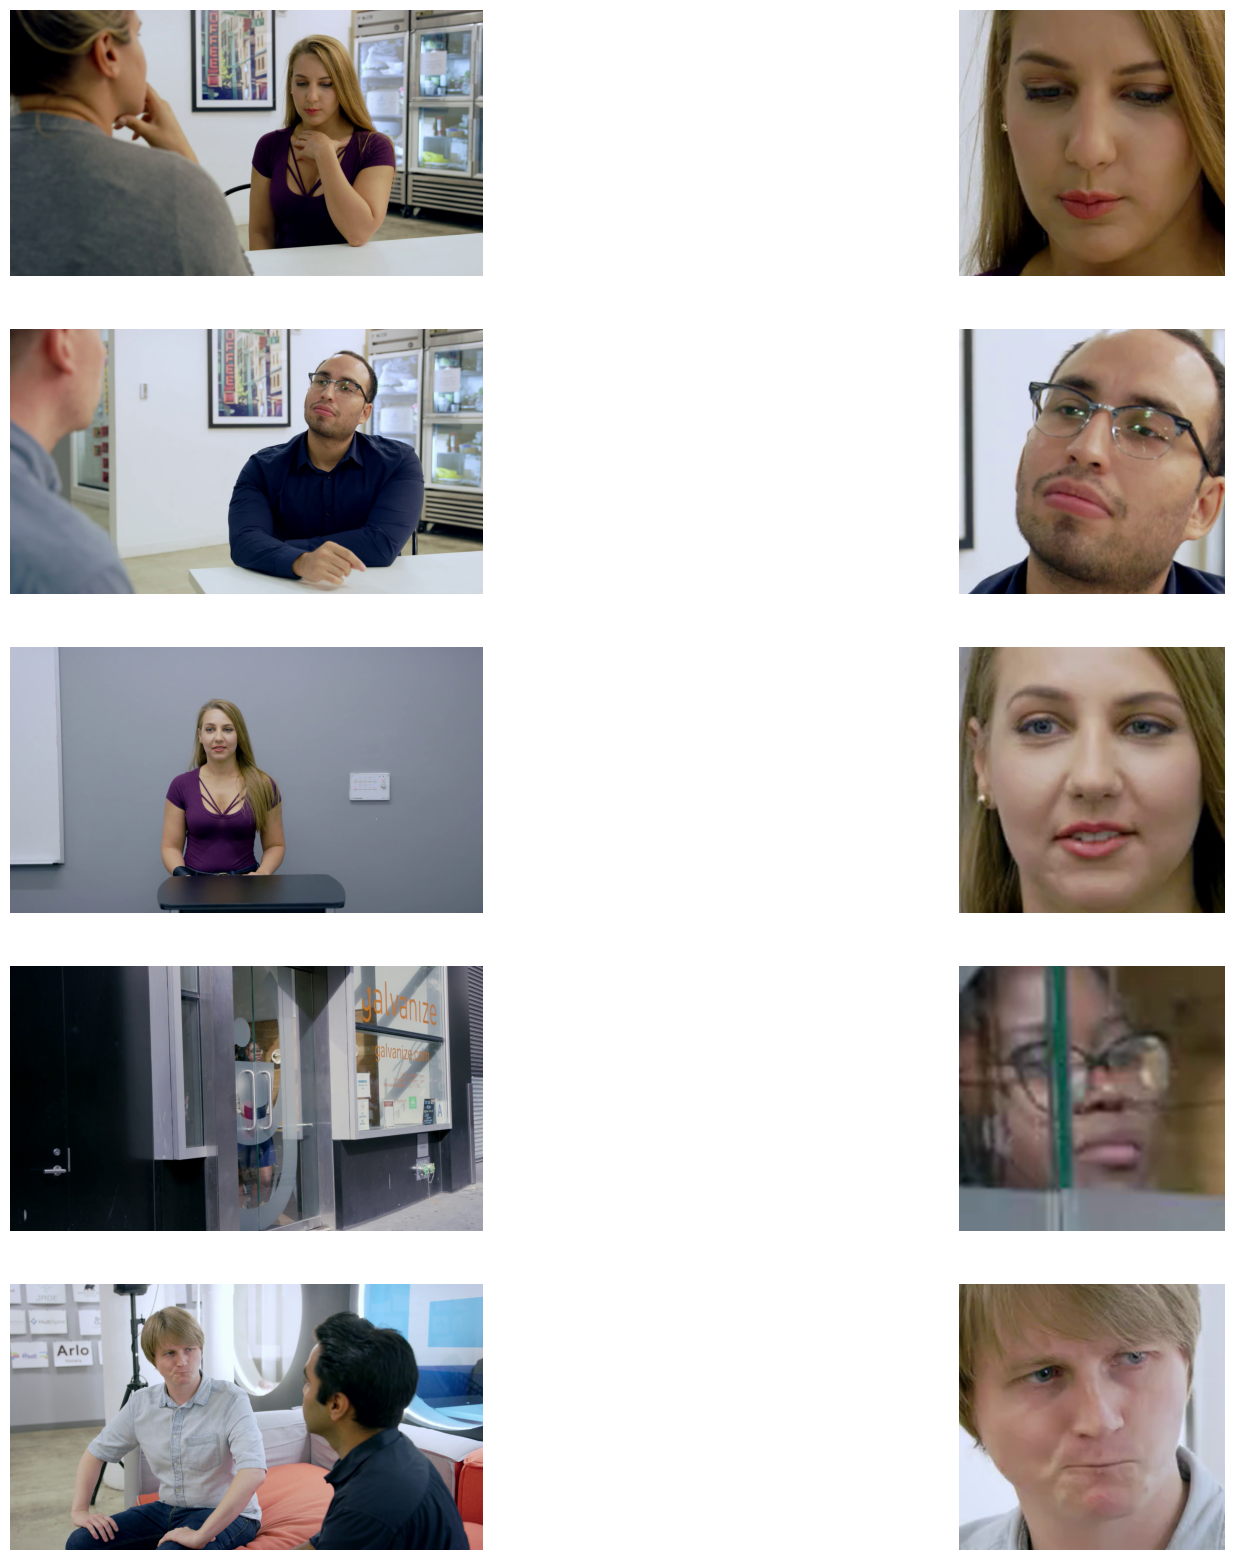

In [11]:
n = len(real_images[:5])

fig, axs = plt.subplots(n, 2, figsize=(20,20))
axs = axs.flatten()

# loop over each image
for i in range(n):
    img = real_images[i]
    axs[2*i].imshow(img)
    axs[2*i].axis('off')
    faces = extract_faces_from_image(img, padding=1.2)
    if len(faces) >= 1:
        axs[2*i+1].imshow(faces[0])
        axs[2*i+1].axis('off')
        
plt.show()

In [12]:
# Load 1 image/dir
fake_images = []
for path in fake_dirs[:1000]:
    fake_images.append(Image.open(path + '0000.png')) # 0000 for the 1st image

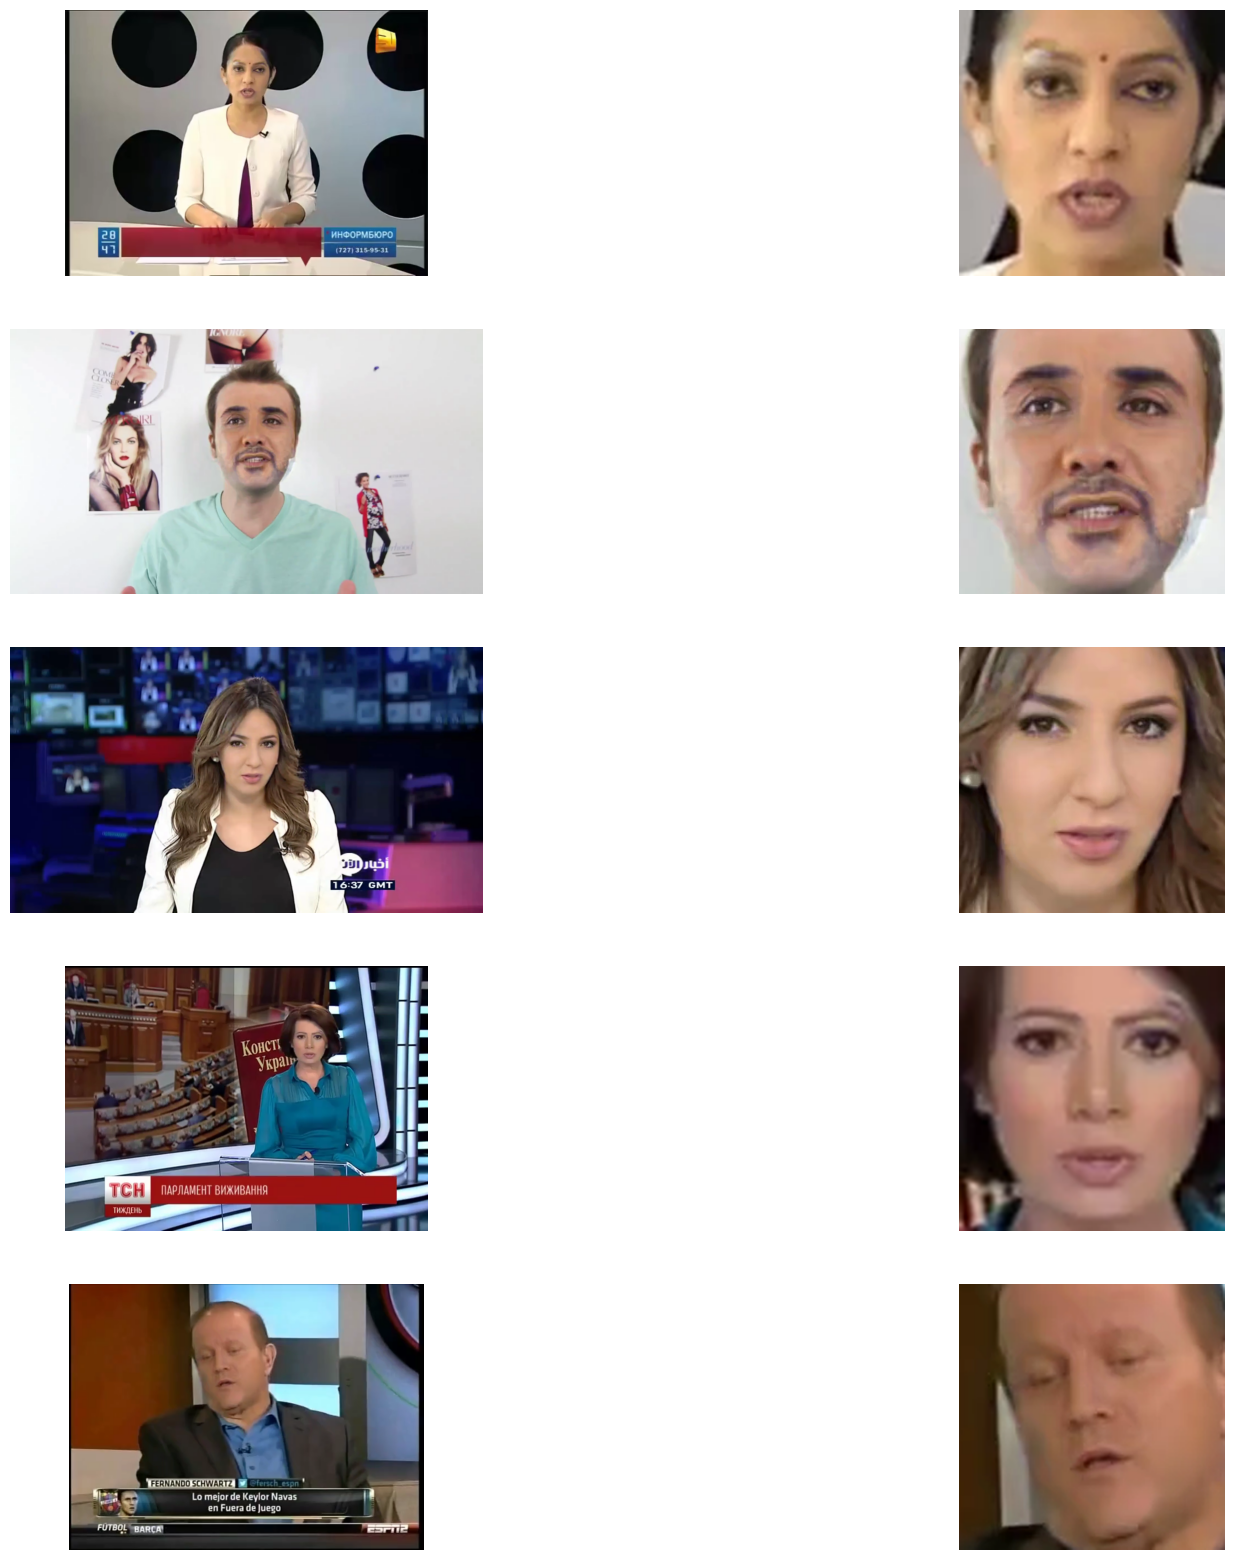

In [13]:
n = len(fake_images[:5])

fig, axs = plt.subplots(n, 2, figsize=(20,20))
axs = axs.flatten()

# loop over each image
for i in range(n):
    img = fake_images[i]
    axs[2*i].imshow(img)
    axs[2*i].axis('off')
    faces = extract_faces_from_image(img, padding=1.2)
    if len(faces) >= 1:
        axs[2*i+1].imshow(faces[0])
        axs[2*i+1].axis('off')
        
plt.show()